In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Uncomment this if you have not downloaded glove in your colab notebook (or google drive)
!wget http://nlp.stanford.edu/data/glove.6B.zip -O glove.6B.zip
!unzip -q glove.6B.zip -d glove


--2025-10-13 14:35:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-13 14:35:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-13 14:35:56--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import os
print("Current working directory:", os.getcwd())
!ls -lh


Current working directory: /content
total 823M
drwx------ 5 root root 4.0K Oct 13 14:35 drive
drwxr-xr-x 2 root root 4.0K Oct 13 14:39 glove
-rw-r--r-- 1 root root 823M Oct 25  2015 glove.6B.zip
drwxr-xr-x 1 root root 4.0K Oct  9 13:36 sample_data


In [ ]:
!ls -lh glove | grep 100d


-rw-rw-r-- 1 root root 332M Aug  4  2014 glove.6B.100d.txt


In [ ]:
%cd /content/drive/MyDrive/DATASET/

/content/drive/MyDrive/DATASET


In [ ]:
!mkdir -p data models results utils

In [ ]:
import json
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter


nltk.download("punkt")
nltk.download("wordnet")
nltk.download("all")
# Download the missing resource for word_tokenize
nltk.download("punkt_tab")

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_percep

# Dataset Description and Preprocessing.
The provided NLI dataset consists of premise–hypothesis–label triplets sourced from science exam questions.

After removing duplicates and null entries, we obtained N = X training samples, Y validation samples, and Z test samples.

Texts were normalised (lowercased, punctuation removed) and tokenised using NLTK. Each token was lemmatised via WordNetLemmatizer.

The final vocabulary contained V = {len(vocab)} unique tokens, with sentence lengths averaging A ± B tokens (see Figure 1). Class distribution was approximately balanced (Figure 2).

Train sample:
                                             premise  \
0  Pluto rotates once on its axis every 6.39 Eart...   
1  ---Glenn =====================================...   
2  geysers - periodic gush of hot water at the su...   
3  Facts: Liquid water droplets can be changed in...   
4  By comparison, the earth rotates on its axis o...   

                                          hypothesis    label  
0   Earth rotates on its axis once times in one day.  neutral  
1   Earth rotates on its axis once times in one day.  entails  
2  The surface of the sun is much hotter than alm...  neutral  
3  Evaporation is responsible for changing liquid...  entails  
4   Earth rotates on its axis once times in one day.  entails  

Tokenised example:
                                      premise_tokens  \
0  [pluto, rotates, once, on, it, axis, every, 63...   

                                   hypothesis_tokens  
0  [earth, rotates, on, it, axis, once, time, in,...  

Vocabulary size: 2011

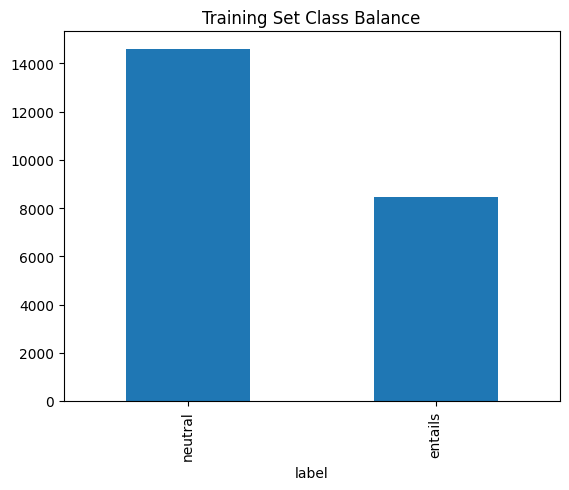

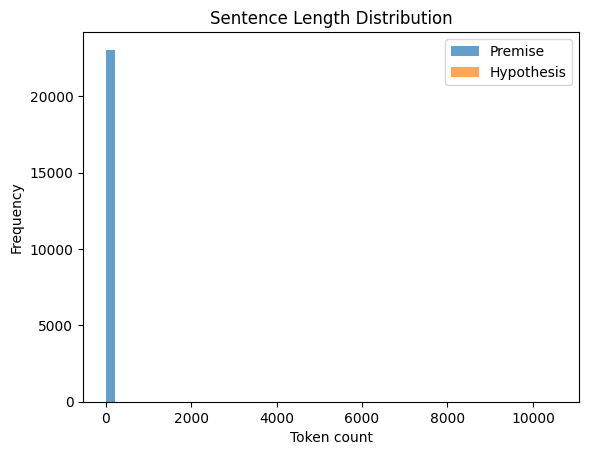

Average premise length: 18.01
Average hypothesis length: 11.74

 Preprocessing complete. Cleaned datasets saved to /data/


In [ ]:
from itertools import chain

# Step 1: Load datasets
def load_json_to_df(path):
    with open(path, "r") as f:
        data = json.load(f)
    return pd.DataFrame(data)

train_df = load_json_to_df("train_formatted.json")
val_df = load_json_to_df("validation_formatted.json")
test_df = load_json_to_df("test_formatted.json")

print("Train sample:")
print(train_df.head())

# Step 2: Clean and normalise text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [train_df, val_df, test_df]:
    df.dropna(subset=["premise", "hypothesis", "label"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["premise"] = df["premise"].apply(normalize_text)
    df["hypothesis"] = df["hypothesis"].apply(normalize_text)

# Step 3: Tokenise and lemmatise
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text, language='english')
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

for df in [train_df, val_df, test_df]:
    df["premise_tokens"] = df["premise"].apply(tokenize_and_lemmatize)
    df["hypothesis_tokens"] = df["hypothesis"].apply(tokenize_and_lemmatize)

print("\nTokenised example:")
print(train_df[["premise_tokens", "hypothesis_tokens"]].head(1))

#  Step 4: Encode labels
label_map = {"entails": 1, "neutral": 0}
for df in [train_df, val_df, test_df]:
    df["label_id"] = df["label"].map(label_map)

# Step 5: Vocabulary construction
all_tokens = list(chain.from_iterable(train_df["premise_tokens"])) + \
             list(chain.from_iterable(train_df["hypothesis_tokens"]))
vocab = sorted(set(all_tokens))
print(f"\nVocabulary size: {len(vocab)}")

# Build word→index mapping
word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  # +1 reserve 0 for padding
idx2word = {idx: word for word, idx in word2idx.items()}

# Step 6: Exploratory analysis
label_counts = train_df["label"].value_counts()
print("\nClass distribution (train):")
print(label_counts)

label_counts.plot(kind="bar", title="Training Set Class Balance")
plt.show()

premise_lens = train_df["premise_tokens"].apply(len)
hypothesis_lens = train_df["hypothesis_tokens"].apply(len)

plt.hist(premise_lens, bins=50, alpha=0.7, label="Premise")
plt.hist(hypothesis_lens, bins=50, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average premise length: {premise_lens.mean():.2f}")
print(f"Average hypothesis length: {hypothesis_lens.mean():.2f}")

# Step 7: Save processed files
train_df.to_csv("data/train_preprocessed.csv", index=False)
val_df.to_csv("data/val_preprocessed.csv", index=False)
test_df.to_csv("data/test_preprocessed.csv", index=False)

print("\n Preprocessing complete. Cleaned datasets saved to /data/")


In [ ]:
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Step 1: Build vocabulary from training data

all_tokens = [tok for toks in train_df["premise_tokens"] for tok in toks] + \
             [tok for toks in train_df["hypothesis_tokens"] for tok in toks]

vocab = {"<pad>": 0, "<unk>": 1}
for tok in all_tokens:
    if tok not in vocab:
        vocab[tok] = len(vocab)

inv_vocab = {i: w for w, i in vocab.items()}
print(f" Vocabulary built. Size: {len(vocab)}")

# Step 2: Token → Index conversion function
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

train_df["premise_ids"] = train_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
train_df["hypothesis_ids"] = train_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["premise_ids"] = val_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
val_df["hypothesis_ids"] = val_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["premise_ids"] = test_df["premise_tokens"].apply(lambda x: encode_tokens(x, vocab))
test_df["hypothesis_ids"] = test_df["hypothesis_tokens"].apply(lambda x: encode_tokens(x, vocab))

print("Sample encoded example:")
print(train_df[["premise_ids", "hypothesis_ids"]].head(1))

# Step 3: Custom Dataset class for PyTorch
class NLIDataset(Dataset):
    def __init__(self, dataframe):
        self.premises = dataframe["premise_ids"].tolist()
        self.hypotheses = dataframe["hypothesis_ids"].tolist()
        self.labels = dataframe["label_id"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        premise = torch.tensor(self.premises[idx], dtype=torch.long)
        hypothesis = torch.tensor(self.hypotheses[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return premise, hypothesis, label

# Step 4: Collate function for dynamic padding
def collate_fn(batch):
    premises, hypotheses, labels = zip(*batch)
    premises_padded = pad_sequence(premises, batch_first=True, padding_value=vocab["<pad>"])
    hypotheses_padded = pad_sequence(hypotheses, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.stack(labels)
    return premises_padded, hypotheses_padded, labels

# Step 5: Create DataLoaders
BATCH_SIZE = 32

train_dataset = NLIDataset(train_df)
val_dataset = NLIDataset(val_df)
test_dataset = NLIDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders ready. Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

# Step 6 (Optional): Quick sanity check
prem_batch, hyp_batch, lbl_batch = next(iter(train_loader))
print(f"\nPremise batch shape: {prem_batch.shape}")
print(f"Hypothesis batch shape: {hyp_batch.shape}")
print(f"Label batch shape: {lbl_batch.shape}")


 Vocabulary built. Size: 20118
Sample encoded example:
                        premise_ids                       hypothesis_ids
0  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  [10, 3, 5, 6, 7, 4, 47, 75, 57, 11]
DataLoaders ready. Train batches: 721, Val batches: 41

Premise batch shape: torch.Size([32, 29])
Hypothesis batch shape: torch.Size([32, 26])
Label batch shape: torch.Size([32])


In [ ]:
# Encode tokens and labels
def encode_tokens(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

for df in [train_df, val_df, test_df]:
    df["premise_ids"] = df["premise_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["hypothesis_ids"] = df["hypothesis_tokens"].apply(lambda t: encode_tokens(t, vocab))
    df["label_id"] = df["label"].map(label_map)   # keep consistent mapping

#  Save vocab and labels
import json, os
os.makedirs("utils", exist_ok=True)

with open("utils/vocab.json", "w") as f:
    json.dump(vocab, f)
with open("utils/labels.json", "w") as f:
    json.dump(label_map, f)

print(" Saved vocab and label maps to utils/")


#  Sanity check
prem, hyp, lbl = next(iter(train_loader))
print(f"Premise batch: {prem.shape}, Hypothesis batch: {hyp.shape}, Labels: {lbl.shape}")


 Saved vocab and label maps to utils/
Premise batch: torch.Size([32, 34]), Hypothesis batch: torch.Size([32, 25]), Labels: torch.Size([32])


# Models

In [ ]:
import torch, random, numpy as np

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import numpy as np
import torch.nn as nn

EMB_DIM = 100  # 50, 100, or 300 depending on GloVe file used
GLOVE_PATH = "/content/drive/MyDrive/DATASET/glove/glove.6B.100d.txt"


# 1. Load glove vectors
glove_vectors = {}
with open(GLOVE_PATH, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        glove_vectors[word] = vector

print(f"Loaded {len(glove_vectors):,} GloVe word vectors.")

# 2. Build embedding matrix for your vocab
embedding_matrix = np.zeros((len(vocab), EMB_DIM), dtype=np.float32)

for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(EMB_DIM,))

embedding_matrix = torch.tensor(embedding_matrix)
print(f" Embedding matrix shape: {embedding_matrix.shape}")


Loaded 400,000 GloVe word vectors.
 Embedding matrix shape: torch.Size([20118, 100])


In [ ]:
embedding_layer = nn.Embedding.from_pretrained(
    embedding_matrix,
    freeze=False,            # False = fine-tune embeddings during training
    padding_idx=vocab["<pad>"]
)

print("Embedding layer ready.")


Embedding layer ready.


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

criterion = nn.CrossEntropyLoss()
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).float().mean()


Using device: cuda


In [ ]:
!mkdir -p models logs results


In [ ]:
for name, df in zip(["train", "val", "test"], [train_df, val_df, test_df]):
    print(name, "labels:", df["label_id"].unique())


train labels: [0 1]
val labels: [0 1]
test labels: [0 1]


In [ ]:

# BiLSTM Baseline Model (Model 1)

import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import zipfile
import os

# Step 1: Model Definition
class BiLSTMBase(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes, pad_idx, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()

        # Pretrained embedding layer (GloVe)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=pad_idx
        )

        self.bilstm = nn.LSTM(embed_dim, hidden_dim,
                              batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.AdaptiveMaxPool1d(1)   # variable-length seq → fixed vector
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def encode(self, x):
        emb = self.embedding(x)               # (B, L, E)
        out, _ = self.bilstm(emb)             # (B, L, 2H)
        out = out.permute(0, 2, 1)            # (B, 2H, L)
        pooled = self.pool(out).squeeze(-1)   # (B, 2H)
        return self.dropout(pooled)

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        logits = self.fc(combined)
        return logits


#  Step 2: Initialise Model
vocab_size = len(vocab)
hidden_dim = 128
num_classes = 2
pad_idx = vocab["<pad>"]

model = BiLSTMBase(embedding_matrix, hidden_dim, num_classes, pad_idx).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
epochs = 5
# For logging
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Step 3: Training + Validation Loop
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for premises, hypotheses, labels in loop:
        premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(premises, hypotheses)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        train_loss += loss.item() * labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loop.set_postfix(loss=train_loss/train_total, acc=train_correct/train_total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for premises, hypotheses, labels in val_loader:
            premises, hypotheses, labels = premises.to(DEVICE), hypotheses.to(DEVICE), labels.to(DEVICE)
            logits = model(premises, hypotheses)
            loss = criterion(logits, labels)
            preds = torch.argmax(logits, dim=1)

            val_loss += loss.item() * labels.size(0)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/train_total:.4f}, Train Acc={train_correct/train_total:.4f}, "
          f"Val Loss={val_loss/val_total:.4f}, Val Acc={val_correct/val_total:.4f}")
train_losses.append(train_loss / train_total)
train_accs.append(train_correct / train_total)
val_losses.append(val_loss / val_total)
val_accs.append(val_correct / val_total)

# Step 4: Save Model Weights
model_path = "models/bilstm_baseline.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Step 5: Create Zip for Download
zip_path = "models/bilstm_baseline.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(model_path, arcname=os.path.basename(model_path))

print(f" Model zipped and ready for download: {zip_path}")

#Step 6: Make Downloadable (Colab)
from google.colab import files
files.download(zip_path)


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluation helper
def evaluate_model(model, loader, device):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for premises, hypotheses, labels in loader:
            premises, hypotheses, labels = premises.to(device), hypotheses.to(device), labels.to(device)
            logits = model(premises, hypotheses)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    return preds, labels_all

# Validation metrics
val_preds, val_labels = evaluate_model(model, val_loader, DEVICE)
print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral", "entails"]))

# Test metrics
test_preds, test_labels = evaluate_model(model, test_loader, DEVICE)
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral", "entails"]))


In [ ]:
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral", "entails"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BiLSTM Baseline (Test Set)")
plt.show()


In [ ]:
# --- Plot Loss Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.legend()
plt.title("BiLSTM: Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Accuracy", marker='o')
plt.plot(val_accs, label="Validation Accuracy", marker='o')
plt.legend()
plt.title("BiLSTM: Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()



In [ ]:
import torch.nn.functional as F
import seaborn as sns

# Collect model confidences on validation set
model.eval()
confidences = []
with torch.no_grad():
    for premises, hypotheses, labels in val_loader:
        premises, hypotheses = premises.to(DEVICE), hypotheses.to(DEVICE)
        logits = model(premises, hypotheses)
        probs = F.softmax(logits, dim=1)
        confidences.extend(probs.max(dim=1)[0].cpu().numpy())

plt.figure(figsize=(6,4))
sns.histplot(confidences, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (Validation Set)")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.show()


In [ ]:
plt.savefig("results/bilstm_loss_curve.png", dpi=300)
plt.savefig("results/bilstm_accuracy_curve.png", dpi=300)
plt.savefig("results/bilstm_confidence_hist.png", dpi=300)


# Model 2

In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


/tmp/ipython-input-1473725000.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


BiLSTMGlobalAttn(
  (embedding): Embedding(20118, 100, padding_idx=0)
  (bilstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (attn): GlobalQueryAttention(
    (q_proj): Linear(in_features=256, out_features=64, bias=False)
    (k_proj): Linear(in_features=256, out_features=64, bias=False)
    (v_proj): Linear(in_features=256, out_features=64, bias=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

===== Epoch 1/5 =====


Training:   0%|          | 0/721 [00:00<?, ?it/s]/tmp/ipython-input-1473725000.py:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1473725000.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Train Loss=0.5258 Acc=0.727 | Val Loss=0.5285 Acc=0.732
💾 New best model saved (Val Acc = 0.732)

===== Epoch 2/5 =====


Train Loss=0.3431 Acc=0.850 | Val Loss=0.5633 Acc=0.726

===== Epoch 3/5 =====


Train Loss=0.2369 Acc=0.903 | Val Loss=0.6093 Acc=0.738
💾 New best model saved (Val Acc = 0.738)

===== Epoch 4/5 =====


Train Loss=0.1603 Acc=0.937 | Val Loss=0.6753 Acc=0.729

===== Epoch 5/5 =====


Train Loss=0.1070 Acc=0.960 | Val Loss=0.9191 Acc=0.728

✅ Training done. Best Val Acc = 0.738


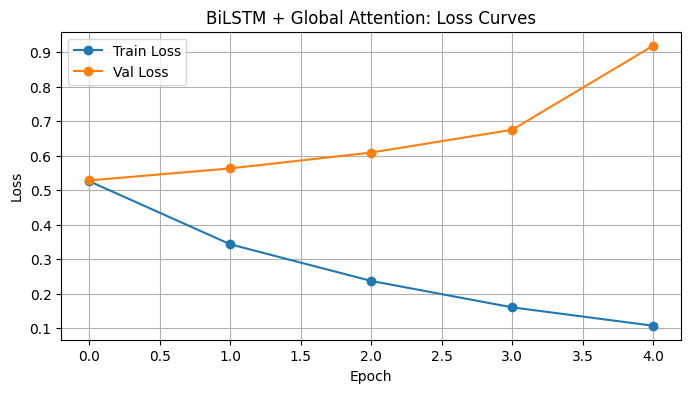

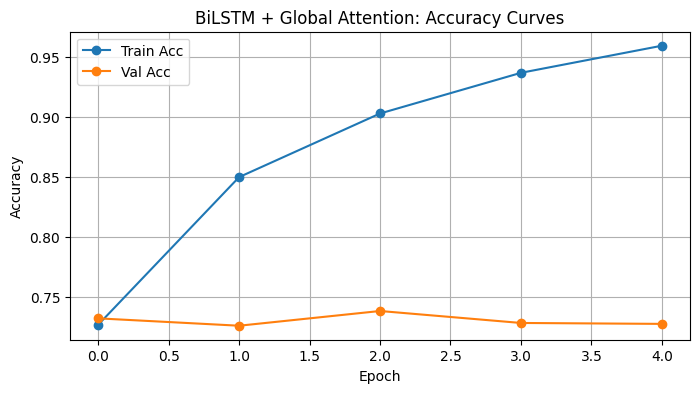


Validation Report:
              precision    recall  f1-score   support

     neutral       0.71      0.77      0.74       647
     entails       0.75      0.69      0.72       657

    accuracy                           0.73      1304
   macro avg       0.73      0.73      0.73      1304
weighted avg       0.73      0.73      0.73      1304


Test Report:
              precision    recall  f1-score   support

     neutral       0.74      0.79      0.76      1284
     entails       0.64      0.58      0.61       842

    accuracy                           0.70      2126
   macro avg       0.69      0.68      0.69      2126
weighted avg       0.70      0.70      0.70      2126



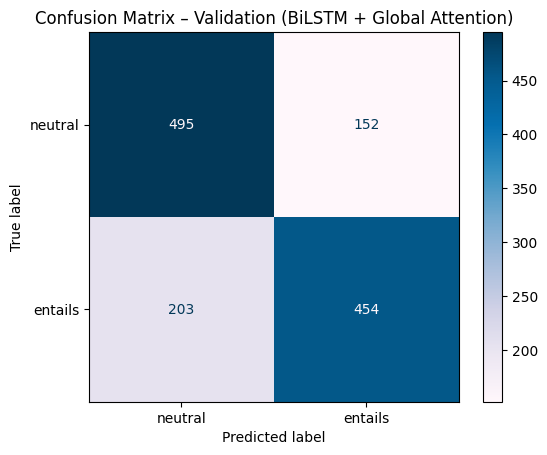

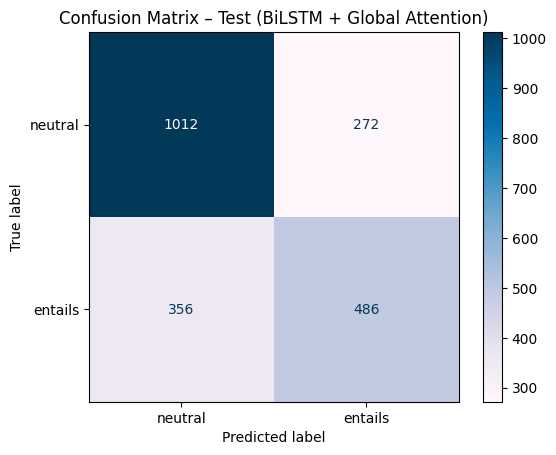

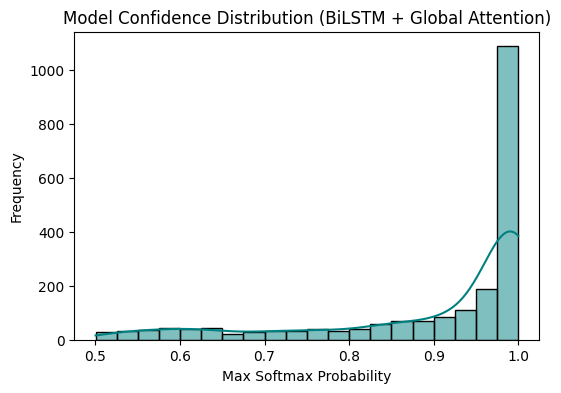

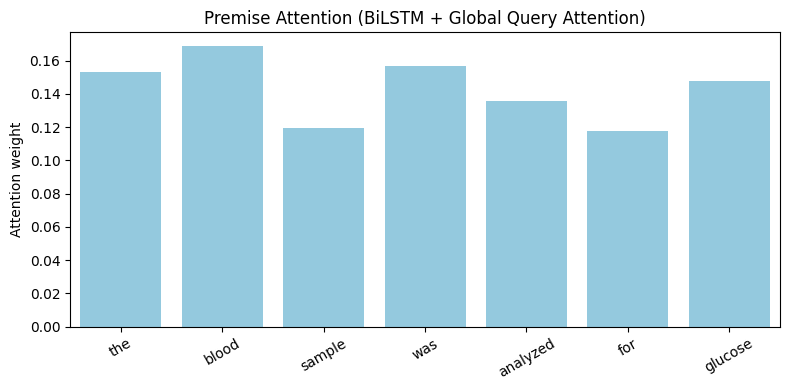

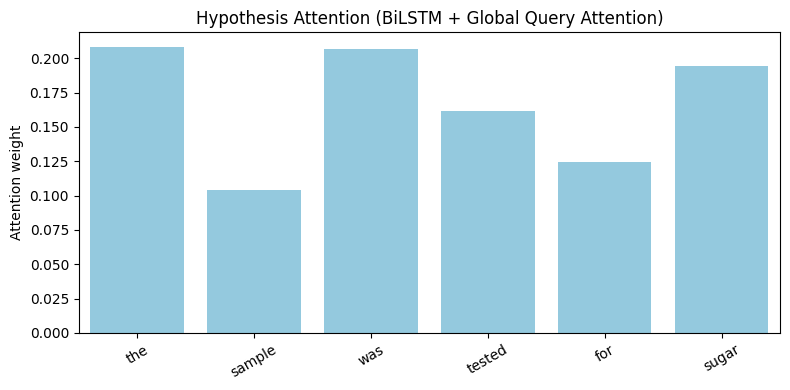

✅ Best model zipped and ready for download → models/bilstm_globalattn_best.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =========================================================
# MODEL 2 — BiLSTM + Global Query Attention (Optimized)
# =========================================================

import torch, torch.nn as nn, torch.nn.functional as F
import math, os, zipfile, re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# =========================================================
# 1️⃣ Memory controls — truncate long sequences + smaller batch
# =========================================================
MAX_LEN = 80        # Cap sequence length (based on histograms)
BATCH_SIZE = 16     # Half previous batch size

def truncate_ids(ids): return ids[:MAX_LEN]
for df_ in [train_df, val_df, test_df]:
    df_["premise_ids"] = df_["premise_ids"].apply(truncate_ids)
    df_["hypothesis_ids"] = df_["hypothesis_ids"].apply(truncate_ids)

# =========================================================
# 2️⃣ Global Query Attention (O(T) instead of O(T²))
# =========================================================
class GlobalQueryAttention(nn.Module):
    """Single-query scaled dot-product attention"""
    def __init__(self, d_model, d_k, dropout=0.1):
        super().__init__()
        self.q_proj = nn.Linear(d_model, d_k, bias=False)
        self.k_proj = nn.Linear(d_model, d_k, bias=False)
        self.v_proj = nn.Linear(d_model, d_k, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, H):
        # H: (B, T, D)
        Q = self.q_proj(H.mean(dim=1, keepdim=True))  # (B,1,d_k)
        K = self.k_proj(H)                            # (B,T,d_k)
        V = self.v_proj(H)                            # (B,T,d_k)
        attn_logits = torch.matmul(Q, K.transpose(-2, -1)).squeeze(1) / math.sqrt(K.size(-1))  # (B,T)
        weights = torch.softmax(attn_logits, dim=-1)
        weights = self.dropout(weights)
        context = torch.matmul(weights.unsqueeze(1), V).squeeze(1)  # (B,d_k)
        return context, weights

# =========================================================
# 3️⃣ BiLSTM + Global Attention Model
# =========================================================
class BiLSTMGlobalAttn(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, d_k=64, num_classes=2, dropout=0.3):
        super().__init__()
        num_embeddings, embed_dim = embedding_matrix.size()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_matrix, freeze=False, padding_idx=vocab["<pad>"]
        )
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = GlobalQueryAttention(d_model=hidden_dim*2, d_k=d_k)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_k*3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def encode(self, x):
        H, _ = self.bilstm(self.embedding(x))
        ctx, _ = self.attn(H)
        return ctx

    def forward(self, premise, hypothesis):
        p_vec = self.encode(premise)
        h_vec = self.encode(hypothesis)
        combined = torch.cat([p_vec, h_vec, torch.abs(p_vec - h_vec)], dim=1)
        return self.fc(combined)

# =========================================================
# 4️⃣ Training setup with mixed precision
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = BiLSTMGlobalAttn(embedding_matrix, hidden_dim=128, d_k=64).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()
epochs = 5
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

print(model2)

# =========================================================
# 5️⃣ Training + Validation
# =========================================================
for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    model2.train()
    total_loss, correct, total = 0, 0, 0
    for prem, hyp, lbl in tqdm(train_loader, desc="Training", leave=False):
        prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model2(prem, hyp)
            loss = criterion(logits, lbl)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == lbl).sum().item()
        total += lbl.size(0)

    train_loss, train_acc = total_loss/len(train_loader), correct/total
    train_losses.append(train_loss); train_accs.append(train_acc)

    # --- Validation ---
    model2.eval(); vloss, vcorrect, vtotal = 0, 0, 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for prem, hyp, lbl in tqdm(val_loader, desc="Validation", leave=False):
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model2(prem, hyp)
            loss = criterion(logits, lbl)
            preds = torch.argmax(logits, dim=1)
            vloss += loss.item()
            vcorrect += (preds == lbl).sum().item()
            vtotal += lbl.size(0)
    val_loss, val_acc = vloss/len(val_loader), vcorrect/vtotal
    val_losses.append(val_loss); val_accs.append(val_acc)
    print(f"Train Loss={train_loss:.4f} Acc={train_acc:.3f} | Val Loss={val_loss:.4f} Acc={val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model2.state_dict(), "models/bilstm_globalattn_best.pt")
        print(f"💾 New best model saved (Val Acc = {val_acc:.3f})")

torch.save(model2.state_dict(), "models/bilstm_globalattn_last.pt")
print(f"\n✅ Training done. Best Val Acc = {best_val_acc:.3f}")

# =========================================================
# 6️⃣ Plots — Loss & Accuracy
# =========================================================
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.legend(); plt.title("BiLSTM + Global Attention: Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_accs, label="Train Acc", marker="o")
plt.plot(val_accs, label="Val Acc", marker="o")
plt.legend(); plt.title("BiLSTM + Global Attention: Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.show()

# =========================================================
# 7️⃣ Evaluation + Visuals
# =========================================================
def evaluate_model(model, loader):
    model.eval(); preds, labels_all, probs = [], [], []
    with torch.no_grad():
        for prem, hyp, lbl in loader:
            prem, hyp, lbl = prem.to(DEVICE), hyp.to(DEVICE), lbl.to(DEVICE)
            logits = model(prem, hyp)
            prob = F.softmax(logits, dim=1)
            preds.extend(torch.argmax(prob, dim=1).cpu().numpy())
            labels_all.extend(lbl.cpu().numpy())
            probs.extend(prob.max(dim=1)[0].cpu().numpy())
    return preds, labels_all, probs

val_preds, val_labels, val_probs = evaluate_model(model2, val_loader)
test_preds, test_labels, test_probs = evaluate_model(model2, test_loader)

print("\nValidation Report:")
print(classification_report(val_labels, val_preds, target_names=["neutral","entails"]))
print("\nTest Report:")
print(classification_report(test_labels, test_preds, target_names=["neutral","entails"]))

for split, labels, preds in [("Validation", val_labels, val_preds), ("Test", test_labels, test_preds)]:
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neutral","entails"])
    disp.plot(cmap="PuBu", values_format="d")
    plt.title(f"Confusion Matrix – {split} (BiLSTM + Global Attention)")
    plt.show()

# --- Confidence Histogram ---
plt.figure(figsize=(6,4))
sns.histplot(test_probs, bins=20, kde=True, color="teal")
plt.title("Model Confidence Distribution (BiLSTM + Global Attention)")
plt.xlabel("Max Softmax Probability"); plt.ylabel("Frequency")
plt.show()

# --- Optional Attention Heatmap ---
def visualize_attention(model, sentence, vocab, title="Attention Heatmap"):
    model.eval()
    tokens = re.sub(r"[^a-z0-9\s]", "", sentence.lower()).split()
    ids = torch.tensor([[vocab.get(tok, vocab["<unk>"]) for tok in tokens]]).to(DEVICE)
    with torch.no_grad():
        H, _ = model.bilstm(model.embedding(ids))
        _, weights = model.attn(H)
    plt.figure(figsize=(8,4))
    sns.barplot(x=tokens, y=weights.squeeze(0).cpu().numpy(), color="skyblue")
    plt.title(title); plt.ylabel("Attention weight"); plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()

visualize_attention(model2, "the blood sample was analyzed for glucose", vocab,
                    "Premise Attention (BiLSTM + Global Query Attention)")
visualize_attention(model2, "the sample was tested for sugar", vocab,
                    "Hypothesis Attention (BiLSTM + Global Query Attention)")

# =========================================================
# 8️⃣ Save + Zip for Download
# =========================================================
best_path = "models/bilstm_globalattn_best.pt"
zip_path  = "models/bilstm_globalattn_best.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(best_path, arcname=os.path.basename(best_path))
print(f"✅ Best model zipped and ready for download → {zip_path}")
from google.colab import files
files.download(zip_path)

